In [3]:
import essentia.standard
import os
import torch
import argparse
import numpy as np
import matplotlib.pyplot as plt

from data import get_dataset
from model import load_model
from utils import post_config_hook

In [26]:
from utils import load_context_config
args = argparse.Namespace()

args.dataset = "magnatagatune"
args.pretrain_dataset = "billboard"
args.model_path = "./logs_backup/audio/billboard/cpc/1"
args.epoch_num = 1490
args.logistic_epochs = 0
args.mlp = 0
args.perc_train_data = 1.0

args.logistic_lr = 0
args.train_stage = 0
args = load_context_config(args)
args.reload = True
args.transfer = False

In [27]:
args.lin_eval = True
args.n_gpu = torch.cuda.device_count()
args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
args.at_least_one_pos = False
args.global_step = 0
args.current_epoch = 0


In [28]:
args.model_name

'cpc'

In [29]:
(train_loader, train_dataset, val_loader, val_dataset, test_loader, test_dataset) = get_dataset(args)

### Linear / Supervised training, using segmented dataset ###
Num segments: 187060
Num tracks: 18706
datasets/audio/billboard/statistics_unlabeled_22050.csv
[Train dataset (billboard_unlabeled_22050)]: Loaded mean/std: -0.0012390311, 0.15724868
### Linear / Supervised training, using segmented dataset ###
Num segments: 18250
Num tracks: 1825
datasets/audio/billboard/statistics_unlabeled_22050.csv
[Validation dataset (billboard_unlabeled_22050)]: Loaded mean/std: -0.0012390311, 0.15724868
### Linear / Supervised training, using segmented dataset ###
Num segments: 53290
Num tracks: 5329
datasets/audio/billboard/statistics_unlabeled_22050.csv
[Test dataset (billboard_unlabeled_22050)]: Loaded mean/std: -0.0012390311, 0.15724868


In [31]:
args.transfer = 1
model, _, scheduler = load_model(
    args, reload_model=True, name=args.model_name
)

model = model.eval()

### InfoNCE Loss ###
### RELOADING CPC MODEL FROM CHECKPOINT 1490 ###
### Using Adam optimizer ###


In [32]:
def tensor_to_audio_sig(tensor):
    return tensor[0].permute(1,0).squeeze(1).cpu().numpy() # swap channel / samples

In [33]:
## adjust model to first 7 layers
import torch.nn as nn

if args.model_name == "clmr":
    if args.new_encoder:
        filter_model = nn.Sequential(*list(model.encoder.children())[0])
    else:
        filter_model = nn.Sequential(*list(model.encoder.children())[:6])
else:
    filter_model = nn.Sequential(*list(model.model.encoder.seq.children())[:7])

filter_model = filter_model.eval()
filter_model

Sequential(
  (0): Sequential(
    (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,), padding=(2,))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv1d(512, 512, kernel_size=(6,), stride=(3,), padding=(2,))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv1d(512, 512, kernel_size=(4,), stride=(2,), padding=(2,))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv1d(512, 512, kernel_size=(4,), stride=(2,), padding=(2,))
    (1): ReLU()
  )
  (4): Sequential(
    (0): Conv1d(512, 512, kernel_size=(4,), stride=(2,), padding=(1,))
    (1): ReLU()
  )
  (5): Sequential(
    (0): Conv1d(512, 512, kernel_size=(2,), stride=(2,), padding=(1,))
    (1): ReLU()
  )
  (6): Sequential(
    (0): Conv1d(512, 512, kernel_size=(2,), stride=(2,), padding=(1,))
    (1): ReLU()
  )
)

In [38]:
import librosa
import librosa.display
import os

if not os.path.exists(f"media/filters_waveform/{args.pretrain_dataset}/{args.model_name}"):
    os.makedirs(f"media/filters_waveform/{args.pretrain_dataset}/{args.model_name}")
    
if not os.path.exists(f"media/filters_spectrum/{args.pretrain_dataset}/{args.model_name}"):
    os.makedirs(f"media/filters_spectrum/{args.pretrain_dataset}/{args.model_name}")

In [39]:
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [40]:
def preprocess_waveform(a):
    a = train_loader.dataset.normalise_audio(torch.from_numpy(a.astype(np.float32)))
    a = torch.tensor(a, requires_grad=True)
    return a

def recreate_waveform(a):
    a = train_loader.dataset.denormalise_audio(a).clone().detach().cpu()
    return a

class CNNAudioVisualisation():
    """
        Produces a spectrum image that minimizes the loss of a convolution
        operation for a specific layer and filter, sorted by magnitude
    """
    def __init__(self, model, selected_layer, selected_filter, device):
        self.model = model
        self.model.eval()
        self.selected_layer = selected_layer
        self.selected_filter = selected_filter
        self.conv_output = 0
        self.device = device


    def hook_layer(self):
        def hook_function(module, grad_in, grad_out):
            # Gets the conv output of the selected filter (from selected layer)
            self.conv_output = grad_out[0, self.selected_filter]
        # Hook the selected layer
        
        # [0] specifies the conv block, [1] batch norm and [2] ReLu
        self.hook = self.model[self.selected_layer][0].register_forward_hook(hook_function)

    def visualise_layer_with_hooks(self, sample_length):
        # Hook the selected layer
        self.hook_layer()
        # Generate a random waveform
        random_waveform = np.random.uniform(-0.5, 0.5, (1, 1, sample_length))
        
        # Process waveform and return variable (autograd)
        processed_waveform = preprocess_waveform(random_waveform)
        
        # Define optimizer for the waveform
        optimizer = torch.optim.Adam([processed_waveform], lr=0.1, weight_decay=1e-6)
        num_steps = 18 # 31
        for i in range(1, num_steps):
            optimizer.zero_grad()
            # Assign create image to a variable to move forward in the model
            x = processed_waveform
            for index, layer in enumerate(self.model):
                x = x.to(self.device)
                # Forward pass layer by layer
                # x is not used after this point because it is only needed to trigger
                # the forward hook function
                x = layer(x)
                # Only need to forward until the selected layer is reached
                if index == self.selected_layer:
                    # (forward hook function triggered)
                    break
                    
            # Loss function is the mean of the output of the selected layer/filter
            # We try to minimize the mean of the output of that specific filter
            loss = -torch.mean(self.conv_output)
            
            if i % 20 == 0:
                print("Iteration:", str(i), "Loss:", "{0:.2f}".format(loss.data))
            # Backward
            loss.backward()
            # Update image
            optimizer.step()
                        
            # Reconstruct waveform
            # self.created_waveform = processed_waveform
            self.created_wavefrom = recreate_waveform(processed_waveform)
            
        # remove hook
        self.hook.remove()
#             # Save image
#             if i % 5 == 0:
#                 im_path = '../generated/layer_vis_l' + str(self.selected_layer) + \
#                     '_f' + str(self.selected_filter) + '_iter' + str(i) + '.jpg'
#                 save_image(self.created_image, im_path)

/home/jspijkervet/miniconda3/envs/clmr/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


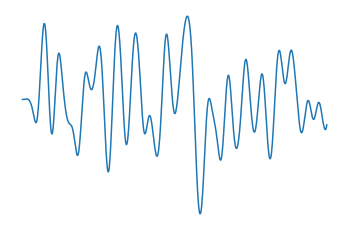

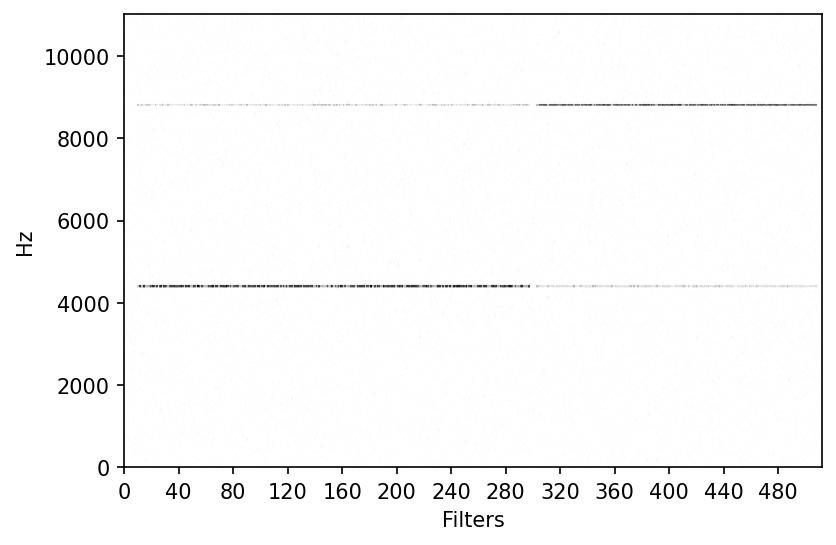

/home/jspijkervet/miniconda3/envs/clmr/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


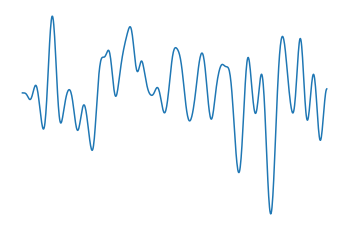

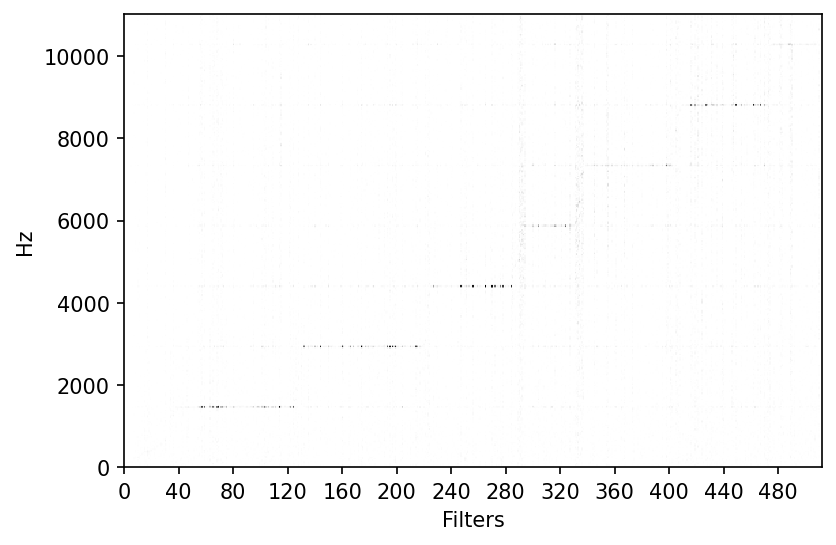

/home/jspijkervet/miniconda3/envs/clmr/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


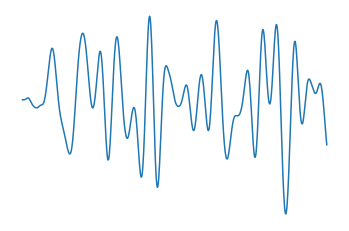

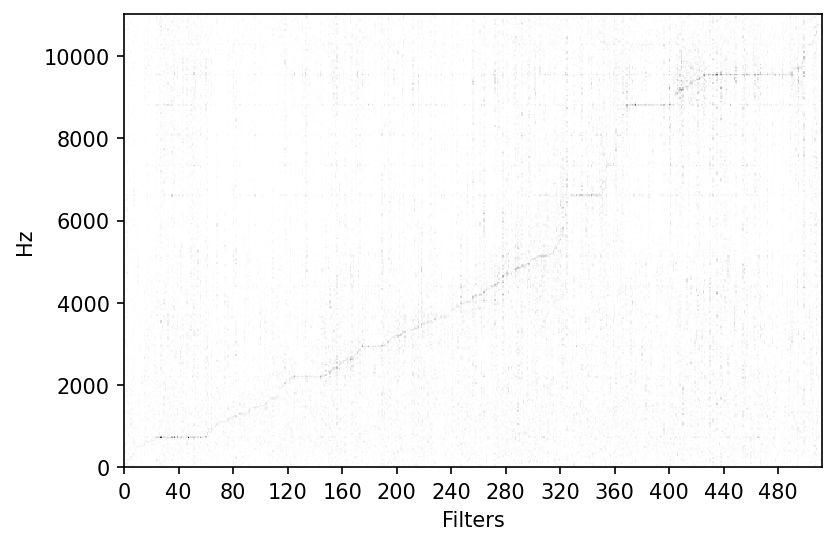

/home/jspijkervet/miniconda3/envs/clmr/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


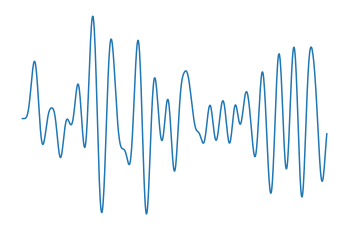

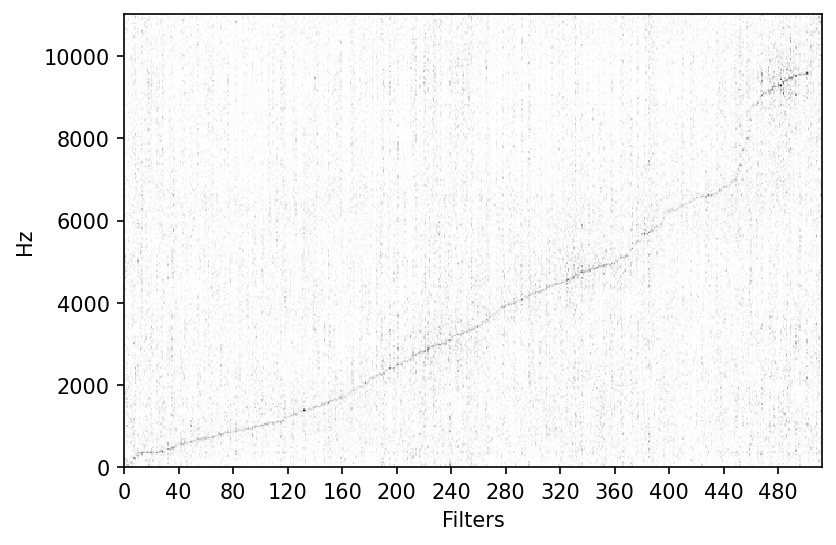

/home/jspijkervet/miniconda3/envs/clmr/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


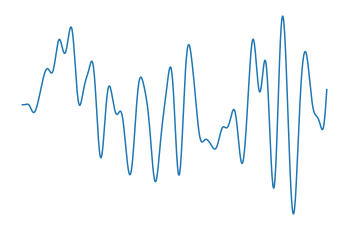

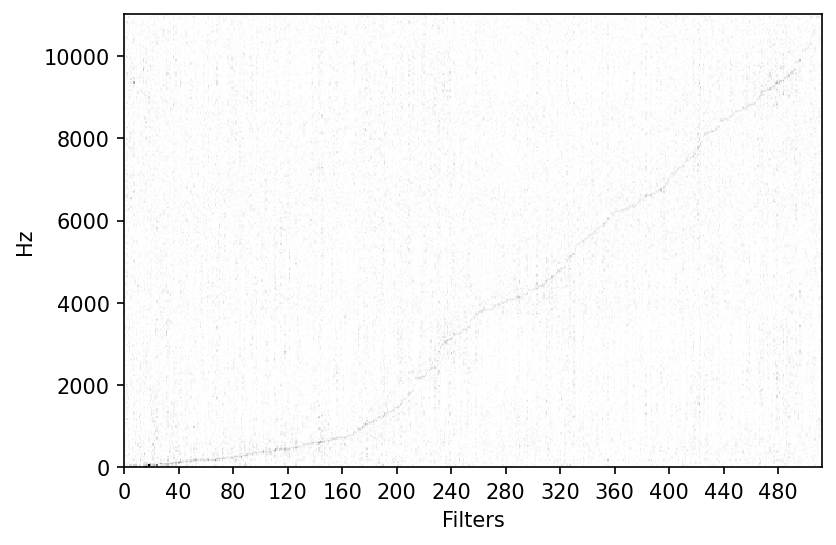

/home/jspijkervet/miniconda3/envs/clmr/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


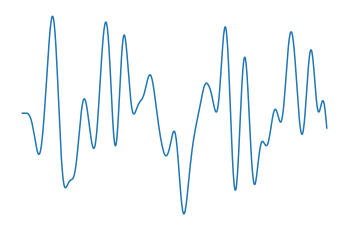

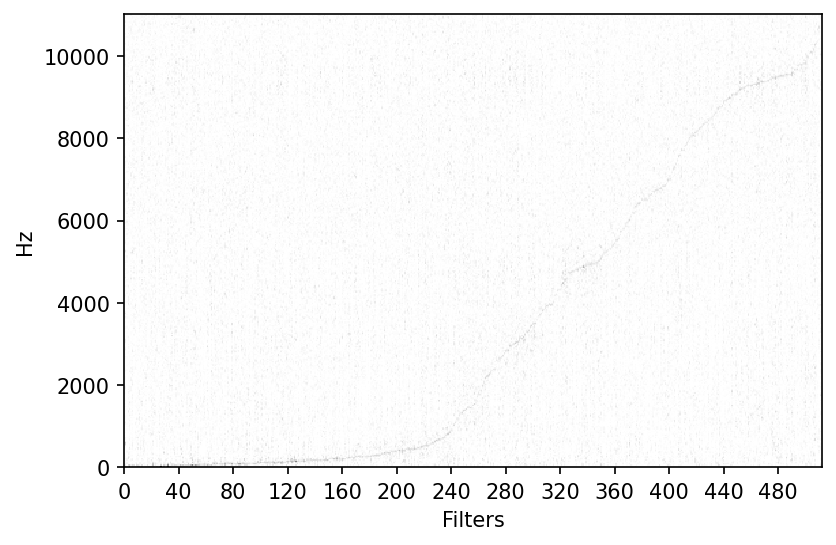

/home/jspijkervet/miniconda3/envs/clmr/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


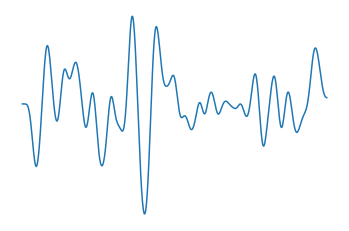

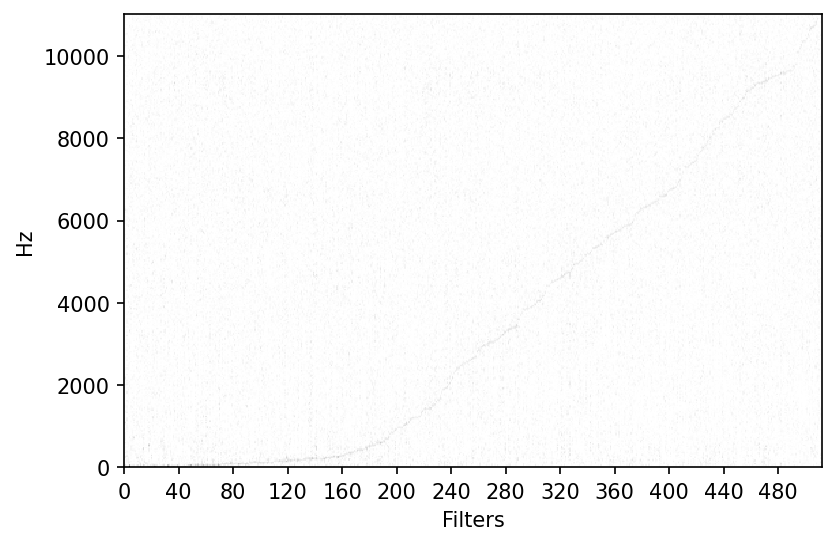

In [41]:
sample_length = 729 # 729
fftsize = 729 # 729

if args.model_name == "clmr":
    if args.new_encoder:
        filters = [512, 512, 512, 512, 512, 512, 512]
    else:
        filters = [128, 128, 128, 256, 256, 256]
else:
    filters = [512, 512, 512, 512, 512, 512, 512, 512]
num_layers = len(filter_model)

for idx, layer_idx in enumerate(range(num_layers)):
    
    num_filters = filters[idx]
    repetition = max(1, int((fftsize/2+1)/num_filters))

    fftzed = np.zeros((num_filters, int(fftsize/2+1)))
    for filter_idx in range(0, num_filters):
        # initialize optimization for layer and filter index
        vis = CNNAudioVisualisation(filter_model, layer_idx, filter_idx, args.device)
        
        # optimize with randomly generaetd waveform of segment length
        vis.visualise_layer_with_hooks(sample_length)
        created_audio = vis.created_wavefrom

        sample = tensor_to_audio_sig(created_audio)
        sample = sample - np.mean(sample) # remove dc

        # only save the last one to save space
        if filter_idx == num_filters-1:
            plt.clf()
            # low-pass sample to get dominant frequencies
            lowpass_sample = butter_lowpass_filter(sample, 600, args.sample_rate, order=6)
            plt.plot(lowpass_sample)
            plt.axis('off')
            plt.savefig(f"./media/filters_waveform/{args.pretrain_dataset}/{args.model_name}/waveform_epoch{args.epoch_num}_layer{layer_idx}_filter{filter_idx}.png")
        
        
        S = librosa.core.stft(sample, n_fft=fftsize, hop_length=fftsize, win_length=fftsize, center=False, window='hamming', dtype=np.complex256)
        
        # Calculate the spectrogram as the square of the complex magnitude of the STFT
        S = np.square(np.absolute(S))
#         log_S = librosa.power_to_db(S, ref=np.max)
#         log_S = np.log10(1+10*X)
        fftzed[filter_idx] = np.squeeze(S.astype(np.float32)) # log_S

    
    argmaxed = np.argmax(fftzed, axis=1)
    sort_idx = np.argsort(argmaxed)
    sorted_fft = fftzed[sort_idx,:]    
    
    plt.figure(dpi=150)
    plt.clf()
    sorted_fft = np.repeat(sorted_fft, repetition, axis=0)
    librosa.display.specshow(sorted_fft.T, cmap='gray_r', y_axis="linear") # log
    

#     plt.imshow(sorted_fft.T, cmap=plt.get_cmap("viridis"))
#     plt.gca().invert_yaxis()
#     plt.axis("off")
    tick_idx = 40
    plt.xticks(np.arange(0, num_filters*repetition, tick_idx), [int(x/repetition) for x in np.arange(0, num_filters*repetition, tick_idx)])
    plt.xlabel("Filters")
    plt.savefig(f"media/filters_spectrum/{args.pretrain_dataset}/{args.model_name}/epoch{args.epoch_num}_layer{layer_idx}.png")
    plt.show()
    

/home/jspijkervet/miniconda3/envs/clmr/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


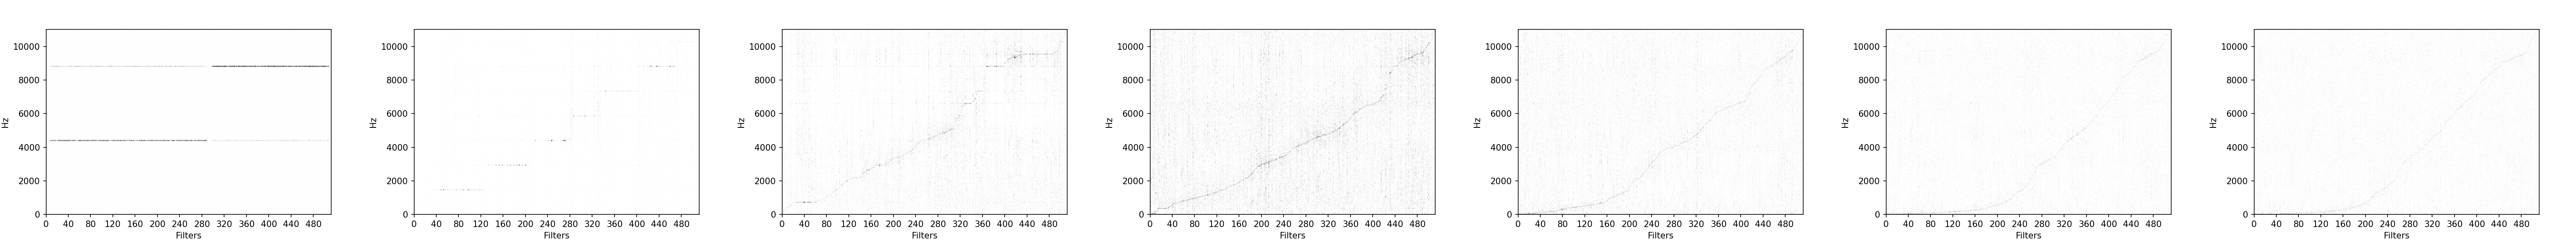

In [23]:
import PIL
from PIL import Image
from IPython.display import display

list_im = [f"./media/filters_spectrum/{args.pretrain_dataset}/{args.model_name}/epoch{args.epoch_num}_layer{layer_idx}.png" for layer_idx in range(num_layers)]
imgs    = [ PIL.Image.open(i) for i in list_im ]
min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]
imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )

imgs_comb = PIL.Image.fromarray(imgs_comb)
# imgs_comb.save("./media/filters_spectrum_combined.png")
display(imgs_comb)

In [ ]:
# create sub-titles

fig, ax = plt.subplots(1, len(list_im), figsize=(100,100))
for idx, i in enumerate(imgs):
    ax[idx].imshow(i)
    ax[idx].axis("off")
    ax[idx].set_title(f"Layer {idx+1}", fontdict={'fontsize': 20, 'fontweight': 'bold'})

plt.axis("off")
plt.savefig(f"./media/filters_spectrum_combined_{args.pretrain_dataset}_{args.model_name}_epoch{args.epoch_num}.png", bbox_inches='tight', pad_inches=1)
plt.show()